# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display

from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.optimize import root_scalar

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import (
    Circle,
    RegularPolygon,
    FancyArrowPatch,
    ArrowStyle,
    Rectangle,
)
from matplotlib.ticker import (
    MultipleLocator,
    FormatStrFormatter,
    AutoMinorLocator,
    NullFormatter,
)
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla
from alens_analysis import rouse_mode_analysis as rma

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path("/home/alamson/DATA/Chromatin/")
mnt_path = Path.home() / "projects/DATA/Chromatin/"
ceph_path = Path.home() / "ceph/DATA/Chromatin/"

In [2]:
# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min = 40

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.grid": True,
}
plt.style.use(graph_sty)
# plt.style.use('bmh')
colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
# plt.rcParams['image.cmap'] = 'emct8'
# plt.rcParams['image.cmap'] = 'warm'
plt.rcParams["image.cmap"] = "YlOrRd"
# plt.rcParams['image.cmap'] = 'twilight'
# plt.rcParams['image.cmap'] = 'coolwarm'
# plt.rcParams['image.cmap'] = 'RdYlBu_r'

In [4]:
slice_path = (
    ceph_path
    / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations"
)

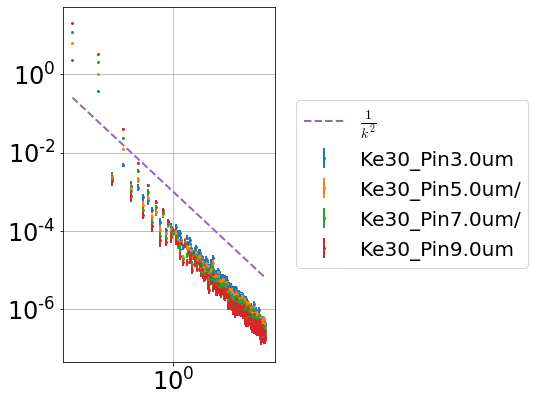

In [13]:

fig, axarr = plt.subplots(figsize=(8, 6), sharex='col', sharey='row' )
# L_sep difference graph
labels_to_graph_dict = {
    3: "Ke30_Pin3.0um",
    5: "Ke30_Pin5.0um/",
    7: "Ke30_Pin7.0um/",
    9: "Ke30_Pin9.0um",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
n_modes = 200

for label, folder in labels_to_graph_dict.items():
    sd_data_list = [sd for sd in (slice_path / folder).glob("s*/analysis/raw_data.h5")]
    power_spec_arr = np.zeros((len(sd_data_list), n_modes))
    for i, sd_data in enumerate(sd_data_list):
        with h5py.File(sd_data, 'r') as h5_data:
            sy_dat = h5_data['raw_data/sylinders'][:,:,1]
            # com_arr = .5*(sy_dat[:,0] + sy_dat[:,1])
            com_arr = .5 * (sy_dat[:, 2:5] + sy_dat[:, 5:8])
            rouse_mode = rma.get_rouse_modes_at_t(com_arr, n_modes=n_modes)
            power_spec = np.einsum('ij,ij->i', rouse_mode, rouse_mode.conj())
            power_spec_arr[i] = power_spec

    polymer_length = sy_dat.shape[0]*.01
    wave_number = np.arange(1, n_modes+1)/polymer_length 
    _ = axarr.errorbar(wave_number, power_spec_arr.mean(axis=0), yerr=power_spec_arr.std(axis=0)/np.sqrt(len(sd_data_list)), label=folder, linestyle='', marker='o')


_ = axarr.plot(wave_number, .001/wave_number**2, label=r'$\frac{1}{k^2}$', linestyle='--')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

fig.tight_layout()

# I need to do a better job analyzing this data but I don't have time right now.


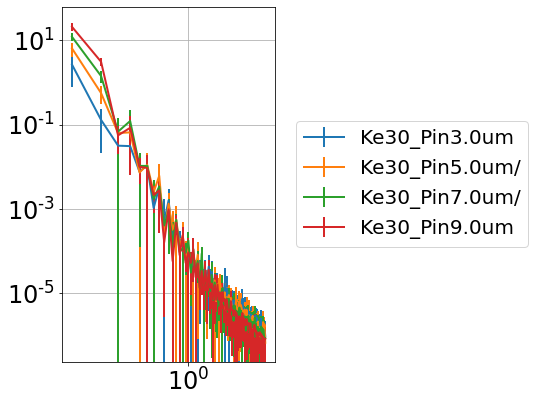

In [30]:

fig, axarr = plt.subplots(figsize=(8, 6), sharex='col', sharey='row' )
# L_sep difference graph
labels_to_graph_dict = {
    3: "Ke30_Pin3.0um",
    5: "Ke30_Pin5.0um/",
    7: "Ke30_Pin7.0um/",
    9: "Ke30_Pin9.0um",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
n_modes = 100

for label, folder in labels_to_graph_dict.items():
    sd_data_list = [sd for sd in (slice_path / folder).glob("s*/analysis/raw_data.h5")]
    power_spec_arr = np.zeros((len(sd_data_list), n_modes))
    for i, sd_data in enumerate(sd_data_list):
        with h5py.File(sd_data, 'r') as h5_data:
            sy_dat = h5_data['raw_data/sylinders'][:,:,-1]
            # com_arr = .5*(sy_dat[:,0] + sy_dat[:,1])
            com_arr = .5 * (sy_dat[:, 2:5] + sy_dat[:, 5:8])
            rouse_mode = rma.get_rouse_modes_at_t(com_arr, n_modes=n_modes)
            power_spec = np.einsum('ij,ij->i', rouse_mode, rouse_mode.conj())
            power_spec_arr[i] = power_spec

    polymer_length = sy_dat.shape[0]*.01
    wave_number = np.arange(1, n_modes+1)/polymer_length 
    _ = axarr.errorbar(wave_number, power_spec_arr.mean(axis=0), yerr=power_spec_arr.std(axis=0), label=folder)


_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

fig.tight_layout()

# I need to do a better job analyzing this data but I don't have time right now.


# Supplement figures